<a href="https://colab.research.google.com/github/danielmlow/tutorials/blob/main/speech_shaped_noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speech-shaped noise

Noise shaped with speech's amplitude. Impose intensity contour (influenced by syllable rate, phonetic structure). 

Not recommended to do with single word, because the strongest segment might be the vowel. So the noise will sound like the vowel and its spectrum will look like the vowel's spectrum.

Steps:
1. Create noise by adding speech segments together
2. Load target audio
2. Apply Hilbert transform to extract envelope.
3. Multiply envelope x noise to obtain 

In [1]:
import os 
import pandas as pd
import numpy as np
import random
import datetime
from scipy.io import wavfile
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import display, Audio
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from sklearn.preprocessing import MinMaxScaler


In [2]:
from google.colab import drive
# Get access to Google Drive and attach it to the colab for data I/O. Follow instructions:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# figure config
plt.rcParams['figure.figsize'] = [12, 2]
plt.rcParams['figure.dpi'] = 120

In [34]:
#@title

# Load audio files from huggingface datasets
# !pip install datasets
# from datasets import load_dataset, load_from_disk
# # dataset = load_dataset('ami', 'headset-single', split='test') 

# load_from_disk("path/to/dataset")
# dataset = load_dataset('ami-wav2vec2/ami_single_headset_segmented_and_chunked')
# # dataset = load_dataset("ami-wav2vec2/ami_single_headset_segmented_and_chunked")


# # https://huggingface.co/datasets/ami
# #other: https://huggingface.co/datasets/timit_asr

# https://huggingface.co/docs/datasets/audio_process.html

# concat many 2 sec speech signals
# speech_samples = []
# for i in list(range(0,dataset.shape[0],5)):
#   data = dataset[i]["audio"]['array']
#   speech_samples.append(data)

# print(np.array(speech_samples).shape, 'audio signal vectors')
# speech_samples = np.concatenate(speech_samples)
# print(speech_samples.shape, 'a single vector concatenated')


# # take random n seconds from concatenated and sum 
# n_seconds = 30
# repeat = 50
# # obtain 1 segment to build the array
# random_start =random.randint(0,len(speech_samples)-(n_seconds*sr))
# speech_noise = speech_samples[random_start:random_start+n_seconds*sr]

# # take 50 more and sum them to that array
# for i in range(repeat):
#   random_start = random.randint(0,len(speech_samples)-(n_seconds*sr))
#   random_n_seconds = speech_samples[random_start:random_start+n_seconds*sr]
#   speech_noise+=random_n_seconds

# # speech_noise = speech_noise/repeat #average



In [6]:
input_dir='/content/drive/My Drive/datum/umass/audio_samples/' #CHANGE TO YOUR PATH

In [7]:
# data = dataset[0]["audio"]['array']
# sr = 16000
sr, data = wavfile.read(input_dir+'oprah_megan.wav')
data = data[:,0]
print(data.shape)
data = data[100000:]
print(data.shape)

(27267072,)
(27167072,)


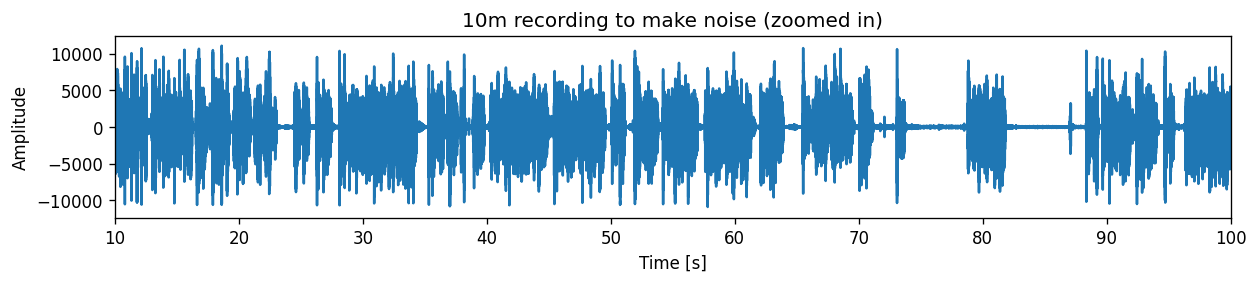

In [8]:
duration = len(data)/sr
time = np.arange(0,duration,1/sr) #time vector
plt.plot(time,data)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
# plt.title(path_to_wav)
plt.title('10m recording to make noise (zoomed in)')
plt.xlim((10,100))
plt.show()

# display(Audio(data=data.T, rate=sr, autoplay=False)) #will make script hang since it is 100MB

In [32]:
# sum N M-sec segements from recording to create noise. 

load_noise = True # if already created, to save time

if load_noise:
  speech_noise = np.load(input_dir+'../speech_noise_oprah_megan.npy')


else:

  repeat = 1000 # N
  n_seconds = 30 # M 


  random_start = random.randint(0,len(data)-(n_seconds*sr))
  speech_noise = data[random_start:random_start+n_seconds*sr] #get random 30 seconds
  speech_noise = np.divide(speech_noise, max(abs(speech_noise))) #normalize


  for i in range(repeat):
    random_start = random.randint(0,len(data)-(n_seconds*sr))
    random_n_seconds = data[random_start:random_start+n_seconds*sr] #get random 30 seconds
    random_n_seconds = np.divide(random_n_seconds, max(abs(random_n_seconds))) #normalize
    speech_noise= np.add(speech_noise,random_n_seconds) #add to other segement
    speech_noise = np.divide(speech_noise, max(abs(speech_noise))) #normalize
  np.save(input_dir+'../speech_noise_oprah_megan.npy', speech_noise)

speech_noise.shape

(1323000,)

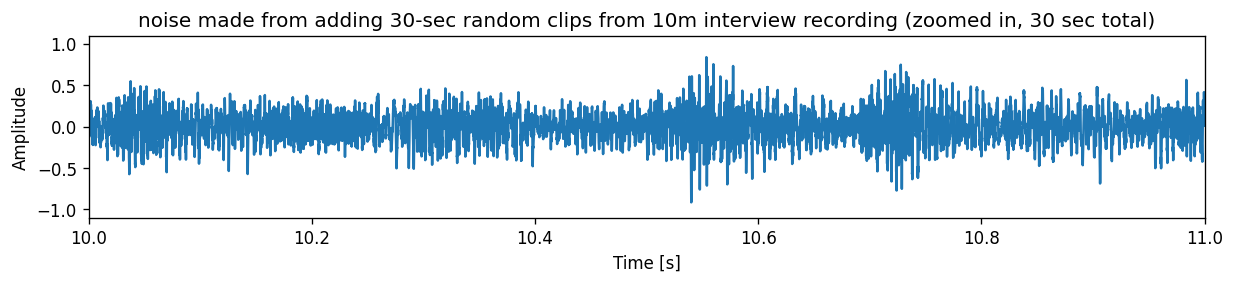

In [33]:
# plot

duration = len(speech_noise)/sr
time = np.arange(0,duration,1/sr) #time vector
plt.plot(time,speech_noise)
plt.xlabel('Time [s]')

plt.ylabel('Amplitude')
plt.xlim((10,11))
plt.title('noise made from adding 30-sec random clips from 10m interview recording (zoomed in, 30 sec total)')
plt.show()
display(Audio(data=speech_noise.T[:200000], rate=sr, autoplay=False))

In [47]:

def speech_shaped_noise(path_to_wav,noise=None,scale = False, gen_figures=True, play_audio=True,save_audio=False, output_path = None):
  # signal
  print('\n\n====='+path_to_wav)
  sr, data = wavfile.read(path_to_wav)
  print(sr)
  data = data [:,0] #extract single channel
  duration = len(data)/sr
  time = np.arange(0,duration,1/sr) #time vector
  scaler = MinMaxScaler()
  # if scale:
  #   data = scaler.fit_transform(data.reshape(-1, 1)).flatten()
  if gen_figures:
    plt.plot(time,data)
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.title(path_to_wav)
    plt.show()
  if play_audio:
    display(Audio(data=data.T, rate=sr, autoplay=False))
  
  # Envelope: extract amplitude envelope through Hilbert transform https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.hilbert.html
  analytic_signal = hilbert(data)
  amplitude_envelope = np.abs(analytic_signal)
  # if scale:
  #   amplitude_envelope = scaler.fit_transform(amplitude_envelope.reshape(-1, 1)).flatten()
  if gen_figures:
    t = np.arange(len(data)) / sr
    signal = plt.plot(t, data, label='signal')
    envelope = plt.plot(t, amplitude_envelope, label='envelope', c='orange',linestyle='dashed', alpha=0.5)
    plt.xlabel("time in seconds")
    plt.xlim((0.3,0.35))
    plt.title('Zoomed in with amplitude envelope displayed')
    plt.show()
  
  # Noise: generate if noise == None, else load noise from argument
  if np.sum(None == None): 
    mean = 0
    std = 1
    num_samples = len(data)
    noise = np.random.normal(mean, std, size=num_samples)
  # if scale:
  #   noise = scaler.fit_transform(noise.reshape(-1, 1)).flatten()
  noise_matched_length = noise[:data.shape[0]] # Take a segment of noise of similar length as audio
  if gen_figures:
    plt.plot(speech_noise)
    plt.title('Speech noise')
    plt.show()
  
  # Speech shaped noise
  speech_shaped_noise = noise_matched_length*amplitude_envelope
  if scale:
    speech_shaped_noise = scaler.fit_transform(speech_shaped_noise.reshape(-1, 1)).flatten()
  if gen_figures:
    plt.plot(speech_shaped_noise)
    plt.title('Speech-shaped noise')
    plt.show()
  if play_audio:
    display(Audio(data=speech_shaped_noise.T, rate=sr, autoplay=False))
  if save_audio:
    wavfile.write(output_path+".wav",sr, speech_shaped_noise.astype(np.int16))
  
  # Plot Speech spectrum
  plt.magnitude_spectrum(data, Fs=sr, scale='dB', color='C1')
  plt.title("Log. Magnitude Spectrum - Speech")
  plt.xlim(0,6000) 
  plt.show()
  
  # Plot Speech-shaped noise spectrum
  plt.magnitude_spectrum(speech_shaped_noise, Fs=sr, scale='dB', color='C1')
  plt.title("Log. Magnitude Spectrum - Speech-shaped noise")
  plt.xlim(0,6000)
  plt.show()
  





=====/content/drive/My Drive/datum/umass/audio_samples/TR_04_OwlBabies Clip.wav
44100


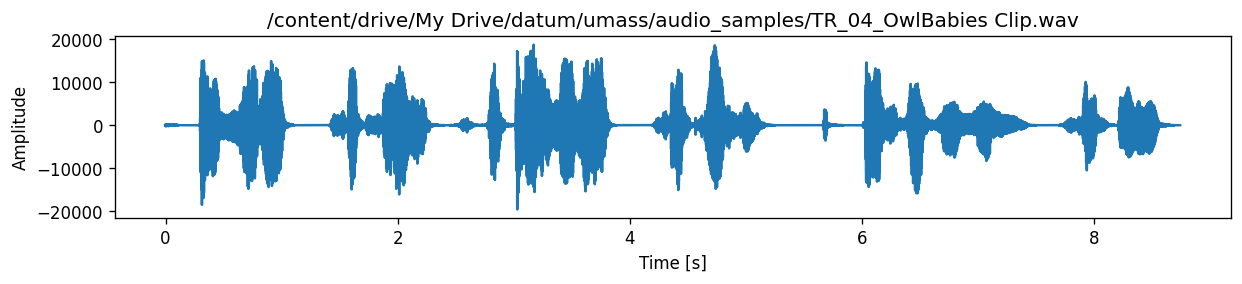

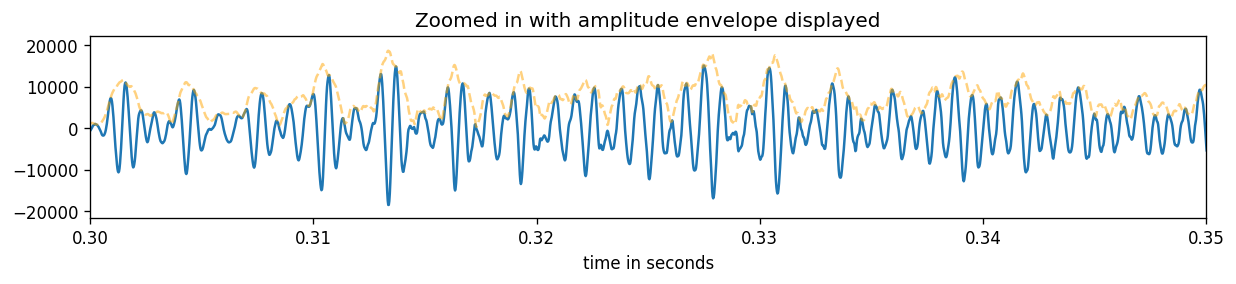

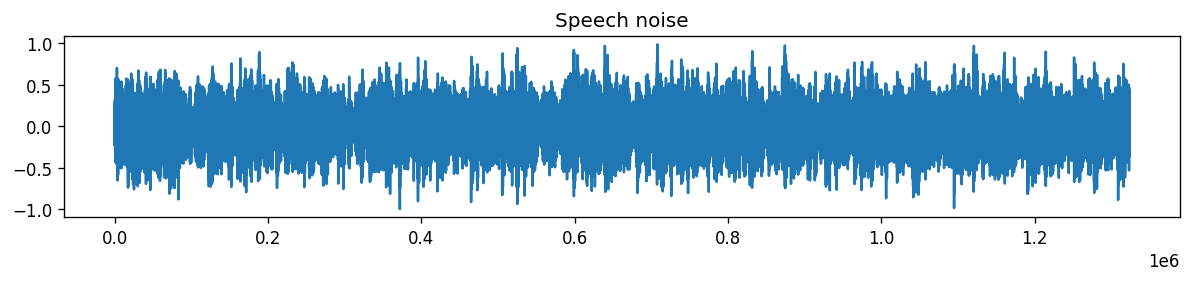

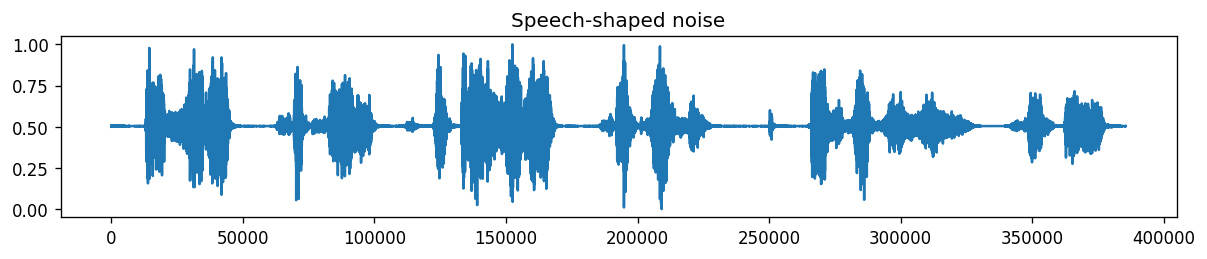

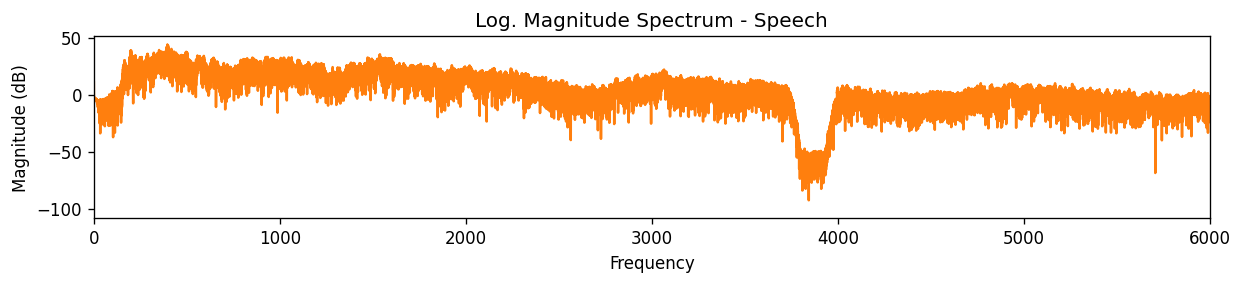

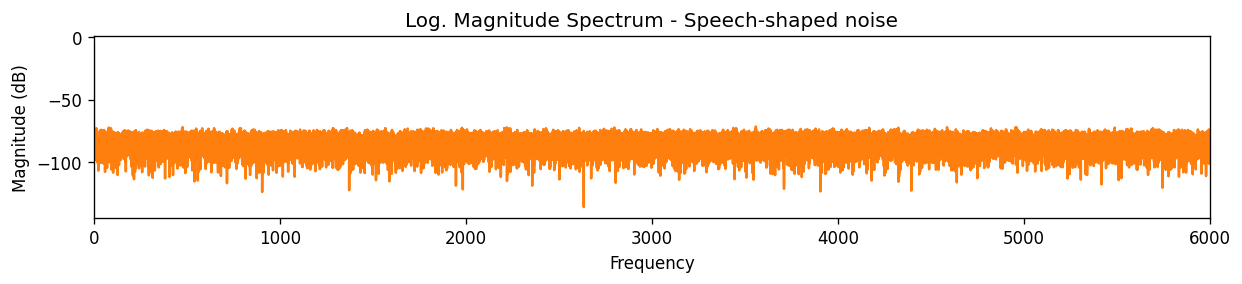

In [48]:
input_dir='/content/drive/My Drive/datum/umass/audio_samples/' #CHANGE TO YOUR PATH
output_dir='/content/drive/My Drive/datum/umass/speech_shaped_noise/' #CHANGE TO YOUR PATH
try: os.mkdir(output_dir)
except: pass

wav_files = ['TR_04_OwlBabies Clip.wav']

for wav_file in wav_files:
  speech_shaped_noise(input_dir+wav_file, 
                      noise=speech_noise, 
                      scale = True, 
                      gen_figures=True, 
                      play_audio=True, 
                      save_audio=True, 
                      output_path = output_dir+wav_file[:-4]
                      )